# TRABAJO FINAL: PROCESAMIENTO DEL LENGUAJE NATURAL

## *Análisis de sentimientos: Las recetas de cocina y Facebook*
### Año 2017
### Integrantes
 * Franco, Laura Sol
 * Marrero Pizarro, Andrés Maximiliano
 * Timpani, Pamela Denise
 * Zamit, Ana Laura

### Objetivo del trabajo
Se implementará un clasificador que permita realizar un análisis de sentimientos a partir de los comentarios realizados por los usuarios de Facebook en publicaciones realizadas por páginas de cocina que contengan recetas.
### Abordaje del desarrollo e implementación del clasificador 
En los pasos que se irán detallando a continuación se indicará cómo se construye el clasificador, con qué bases de datos se cuenta, como se realiza la tokenización de las palabras, limpieza y acondicionamiento de los datos con los que se cuenta, desarrollo del clasificador del tipo no suvervisado en Python.
#### Importación de librerías
Las librerías de Python que se utilizarán para la labor son las siguientes:

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib3
urllib3.disable_warnings()
import json
import datetime
import csv
import time
import numpy as np
import re
import os
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from matplotlib import style
style.use("ggplot")

#### Configuración de la API de Facebook
A continuación se destacan los parámetros utilizados para acceder a las páginas de Facebook de interés como *Upsoclsabores* o *Cucinareok* y tomar los comentarios de los usuarios.

El usuario y la password utilizada junto con el token de acceso, los id de las páginas son:


In [81]:
claves = list(line.strip() for line in open('C:/Users/Kikes/Documents/maestria/NLP/app_clave.txt'))

app_id = claves[0]

app_secret = claves[1] # DO NOT SHARE WITH ANYONE!

access_token = app_id + "|" + app_secret


#recetasdecocinatradicional
#recetasdecocinasabrosas
#recetasdecocinaclasica1
#tastyrecetasdecocina

#page_id = 'nytimes'
#page_id = 'www.salesintacc.com.ar'
#page_id = 'upsoclsabores'
#page_id = 'recetasdecocinatradicional'
#page_id = 'recetasdecocinasabrosas'
#page_id = 'recetasdecocinaclasica1'
#page_id = 'tastyrecetasdecocina'
page_id = 'cucinareok'

Acceso a Facebook: se genera un permiso para ingresar a la aplicación y en caso de error se reinicia la conexión.

In [82]:
def request_until_succeed(url):
    http = urllib3.PoolManager()
    req = http.request('GET', url)
    success = False
    while success is False:
        try:
            response = http.urlopen('GET',url)
            if response.status == 200:
                success = True
        except:
            time.sleep(5)
            
            print ("Error for URL %s: %s" % (url, datetime.datetime.now()))

    return req

Definición de la función de recopilación: en el siguiente fragmento del proceso se define cómo será la función que ingresará en la página de Facebook seleccionada (en este caso _Cucinare_), cuáles son los parámetros a recoger dentro de los que se destacan el comentario y el usuaio que lo realiza.

In [83]:
def getFacebookPageFeedData(page_id, access_token, num_statuses):
    
    # construct the URL string
    base = "https://graph.facebook.com/v2.11" #cambié v2.4 a v2.11, funcionaba igual con v2.4
    node = "/" + page_id + "/feed"
    parameters = "/?fields=message,link,created_time,type,name,id,comments,from,attachment,shares&limit=%s&access_token=%s" % (num_statuses, access_token)
    url = base + node + parameters
    
    # Esto está cambiado respecto al ejemplo
    http = urllib3.PoolManager()
    req = http.request('GET', url)
    data = json.loads(request_until_succeed(url).data.decode('utf-8'))
    return data
    

A continuación, se invoca la función definida en el paso previo junto con los parámetros de la API y se obtienen 100 posts.

In [84]:
#Estoy levantando 100 posts
salida_all = getFacebookPageFeedData(page_id, access_token, 100)

columns = ['post_from', 'post_id', 'post_name', 'post_type', 'post_message', 'post_link', 'post_shares', 'created_time']

df_posts = pd.DataFrame(columns=columns)

Se crea la función que toma la salida de la web y divide los componentes en variables

In [85]:
def scrapPosts(post):
    post_from = '' if 'from' not in post.keys() else post['from']['id']
    post_id = post['id']
    post_name = '' if 'name' not in post.keys() else post['name']
    post_type = '' if 'type' not in post.keys() else post['type']
    post_message = '' if 'message' not in post.keys() else post['message']
    post_link = '' if 'link' not in post.keys() else post['link']
    post_shares = '' if 'shares' not in post.keys() else post['shares']['count']
    created_time = datetime.datetime.strptime(post['created_time'],'%Y-%m-%dT%H:%M:%S+0000')
    created_time = created_time + datetime.timedelta(hours=-5) # EST
    created_time = created_time.strftime('%Y-%m-%d %H:%M:%S')    

    return(post_from, post_id, post_name, post_type, post_message, post_link, post_shares, created_time)


Se aplica la función antes creada y de las variables allí generadas se crea un dataset (adicionalmente el dataset es guardado para la posible creación de una base de datos)

In [86]:
n_posts = len(salida_all['data'])

for i in range(n_posts):
    df = pd.DataFrame(list(scrapPosts(salida_all["data"][i])),index = ['post_from', 'post_id', 'post_name', 'post_type', 'post_message', 'post_link', 'post_shares', 'created_time']).transpose()
    df_posts = df_posts.append(df, ignore_index=True)    

df_posts.to_csv( 'df_posts'+page_id+'.csv', encode = 'utf-8' )

Se crea la función que procesa los comentarios en cada post.  Se "expanden" los comentarios creando un registro por cada uno. 

In [87]:
def scrapComments(pos, com):

    post_id = salida_all["data"][pos]["id"]
    comm_id = salida_all["data"][pos]["comments"]["data"][com]["id"]
    comm_msg = salida_all["data"][pos]["comments"]["data"][com]["message"]
    comm_date = datetime.datetime.strptime(salida_all["data"][pos]["comments"]["data"][com]["created_time"],'%Y-%m-%dT%H:%M:%S+0000')
    comm_date = comm_date + datetime.timedelta(hours=-5) # EST
    comm_date = comm_date.strftime('%Y-%m-%d %H:%M:%S') # best time format for spreadsheet programs
    
    return(post_id, comm_id, comm_msg, comm_date)

Se crea el dataset que va a guardar los comentarios

In [88]:
df_comms = pd.DataFrame(columns=['post_id','comm_id','comm_msg','comm_date'])

Se aplica la función que crea traduce comentarios en registros

In [90]:
#n_posts = len(salida_all['data'])

for i in range(n_posts):
    if len(salida_all["data"][i]) <= 8:
        continue
    ncomm = len(salida_all["data"][i]["comments"]["data"])
    for c in range(ncomm):
        df = pd.DataFrame(list(scrapComments(i,c)), index=['post_id','comm_id','comm_msg','comm_date']).transpose()
        df_comms = df_comms.append(df, ignore_index=True)        

Se crean todos los patrones necesarios para extraer y clasificar emojies de los comentarios

In [91]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

df_comms['emojis'] = df_comms['comm_msg'].apply(lambda x: emoji_pattern.findall(x))
df_comms['emojis'] = df_comms['emojis'].apply(lambda x: ''.join(x))
df_comms['comm_msg'] = df_comms['comm_msg'].apply(lambda x: emoji_pattern.sub(r'', x))
df_comms['emojis_count'] = df_comms.emojis.str.len()

emoji_pos = '[\U0001F600|\U0001F601|\U0001F602|\U0001F923|\U0001F603|"\
    "\U0001F604|\U0001F605|\U0001F606|\U0001F609|\U0001F60A|"\
    "\U0001F60B|\U0001F60E|\U0001F60D|\U0001F618|\U0001F617|"\
    "\U0001F619|\U0001F61A|\U0001F642|\U0001F917|\U0001F929]+'


emoji_neg = '[\U0001F641|\U0001F616|\U0001F61E|\U0001F61F|\U0001F624|\U0001F92C|"\
    "\U0001F622|\U0001F62D|\U0001F626|\U0001F627|\U0001F628|"\
    "\U0001F629|\U0001F92F|\U0001F62C|\U0001F630|\U0001F631|"\
    "\U0001F633|\U0001F92A|\U0001F635|\U0001F621|\U0001F620|]+'

df_comms['emojis_pos'] = df_comms['emojis'].apply(lambda x: re.findall(emoji_pos,x))
df_comms['emojis_pos'] = df_comms['emojis_pos'].apply(lambda x: ''.join(x))
df_comms['emojis_pos_count'] = df_comms.emojis_pos.str.len()

df_comms['emojis_neg'] = df_comms['emojis'].apply(lambda x: re.findall(emoji_neg,x))
df_comms['emojis_neg'] = df_comms['emojis_neg'].apply(lambda x: ''.join(x))
df_comms['emojis_neg_count'] = df_comms.emojis_neg.str.len()

cant_neutros = df_comms['emojis_count'] - df_comms['emojis_neg_count'] - df_comms['emojis_pos_count']

df_comms['emojis_neutros_count'] = cant_neutros


Guardamos la tabla de comentarios para su posterior manipulación

In [92]:
df_comms.to_csv( 'df_comms_'+page_id+'.csv', encoding = 'utf-8')

## Comienza el proceso de NER tagging & feature engineering ##

Se trabaja sobre una copia del dataset original

In [93]:
#df = df_comms.copy().head(10)
df = df_comms.copy()

Creación de la variable "solo emojis" y drop de registros sin comentarios

In [94]:
df['comm_msg'].replace('', np.nan, inplace = True)
df['emojis'].replace('', np.nan, inplace = True)
df['solo_emoji'] = np.where(df.comm_msg.isnull()&df.emojis.notnull(),1,0)
df.dropna( subset = ['comm_msg', 'solo_emoji'], inplace = True, how = 'all' )

se debe referenciar la "java machine" ya que esta es utilizada por la librería *Stanford NER Tagger*

In [95]:
java_path = 'C:/Program Files (x86)/Java/jre1.8.0_131/bin/java.exe'

os.environ['JAVAHOME'] = java_path
os.chdir('C:/Users/Kikes/Documents/maestria/NLP/')
st = StanfordNERTagger('stanford-ner/classifiers/spanish.ancora.distsim.s512.crf.ser.gz',
					   'stanford-ner/stanford-ner.jar',
					   encoding='utf-8')

Función para extraer entidades "nombre" de los comentarios 

In [96]:
def extraeNombres(comm):
    comm_str = str(comm)#comm.to_json()
    #comm_token = word_tokenize(comm_str)
    comm_token = word_tokenize(comm_str)
    #comm_token = word_tokenize(comm)
    comm_class = st.tag(comm_token)
    comm_list_per = [pers for pers in comm_class if pers[1] =='PERS']
    comm_per = re.sub(r'[\[\]\(\)\'\,]', "", str([i[0] for i in comm_list_per]))
    return comm_per

Se aplica la función para "taguear" nombres, se crea una columna nueva con esas entidades y se quitan del comentario

In [97]:
df['nombres'] = df['comm_msg'].apply(lambda x: extraeNombres(x))
df['nombres'].replace( '', np.nan, inplace = True )

#Guardo el dataset para recuperarlo si se corrompe en pasos posteriores
df.to_csv( 'df_con_nombres.csv', encoding = 'utf-8')

n_comm = len(df)

for c in range(n_comm):
    ext_name = str(df.nombres[c])
    ext_comm = str(df.comm_msg[c])
    comm_no_name = ext_comm.replace(ext_name,"")
    df.comm_msg[c] = comm_no_name

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Se crean nuevas variables que sirvan al algoritmo para clasificar:
 * Tiene nombre / emojis: s/n
 * Largo del string (comentario)

In [98]:
df['tiene_nombre'] = np.where( df.nombres.notnull(), 1, 0 )
df['tiene_emoji'] = np.where( df.emojis.notnull(), 1, 0 )
df['comm_msg'].fillna(' ', inplace=True)
df['largo_comm'] = df['comm_msg'].apply(lambda x: len( x.replace(" ","") ))
df['comm_msg'] = df['comm_msg'].apply(lambda x: re.sub(r'[!#$%&\'()*+,-./:;<=>?@\[\]^_`{|}~¡]', " ", x))

Carga de lista con stopWords en español, y creación de función para extraerlas del string

In [99]:
stop = set(stopwords.words('spanish'))
sw2 = set(line.strip() for line in open('stop_words_acentos.txt'))
stop2 = stop|sw2

def quitaStopWords(comm):

    split_comm = comm.lower().split()
    comm_no_stop = [i for i in split_comm if i not in stop2]
    comm_str = ' '.join(comm_no_stop)
    comm_str_no_short = ' '.join(word for word in comm_str.split() if len(word)>2)
    return comm_str_no_short

Se crean más variables predictivas en base al comentario sin stopwords

In [100]:
df['comm_msg_clean'] = df['comm_msg'].apply( lambda x: quitaStopWords( x ) )
df['largo_comm_clean'] = df['comm_msg_clean'].apply(lambda x: len(x.replace(" ","")))
df['ratio_largo_clean'] = df['largo_comm_clean']/df['largo_comm']

### En esta parte del proceso se van a incorporar dos variables que se espera contribuyan sustancialmente a la clasificación.  Utilizando una lista de palabras pre-clasificada como negativo y positivo se crea un ratio que representa la proporción de palabras positivas / negativas presentes en cada comentario

In [101]:
df_posNeg = pd.read_csv('C:/Users/Kikes/Documents/maestria/NLP/palabras_pos_neg.csv', encoding='utf-8', index_col=0)

df_pos = df_posNeg[['Palabra','V.Mean.Sum']][df_posNeg['V.Mean.Sum']>=5]
df_pos.columns = ['palabra', 'valor']
pos_words = set(pd.Series(df_pos.palabra))

df_neg = df_posNeg[['Palabra','V.Mean.Sum']][df_posNeg['V.Mean.Sum']<5]
df_neg.columns = ['palabra', 'valor']
neg_words = set(pd.Series(df_neg.palabra))

def posWords(comm):
    split_comm = comm.lower().split()
    cant_palabras = len(split_comm)
    word_pos = [i for i in split_comm if i in pos_words]
    word_pos2 = ' '.join(word_pos)
    word_pos_count = len(word_pos2.split())
    word_pos_ratio = 0 if word_pos_count == 0 else  word_pos_count/cant_palabras 
    return word_pos_ratio

def negWords(comm):
    split_comm = comm.lower().split()
    cant_palabras = len(split_comm)
    word_neg = [i for i in split_comm if i in neg_words]
    word_neg2 = ' '.join(word_neg)
    word_neg_count = len(word_neg2.split())
    word_neg_ratio = 0 if word_neg_count == 0 else  word_neg_count/cant_palabras 
    return word_neg_ratio

df['pos'] = df['comm_msg_clean'].apply( lambda x: posWords( x ) )
df['neg'] = df['comm_msg_clean'].apply( lambda x: negWords( x ) )

Se crea un nuevo dataset para entrenar con el algoritmo kmeans, dejando solo variables predictivas numéricas y se exporta 
para el siguiente paso.  También se exporta el dataset completo para poder asignarle clusters luego de la clasificación.

In [115]:
df_km = df[df.comm_msg_clean!='']
#df_km = df[['comm_id','emojis_count','emojis_pos_count','emojis_neg_count','solo_emoji','tiene_nombre','tiene_emoji','largo_comm','largo_comm_clean','ratio_largo_clean','pos','neg']]
df_km = df[['comm_id','emojis_pos_count','emojis_neg_count','pos','neg']]
df_km.to_csv( 'df_para_km.csv', encoding = 'utf-8')
df_final = df[df.comm_msg_clean!='']
df_final.to_csv( 'df_final.csv', encoding = 'utf-8')

### Utilizando el algoritmo k-means se crearán 3 cluster que deberían representar:
### - Comentarios positivos
### - Comentarios negativos
### - Comentarios neutros

Se normalizan los valores de la matriz input para facilitar y mejorar el trabajo de clasificación del algoritmo

In [116]:
del df_km['comm_id']
normalized_df = (df_km-df_km.mean())/df_km.std()
normalized_df.fillna(value=0, inplace=True)
km = KMeans(n_clusters = 3)
km.fit(normalized_df)
predict=km.predict(normalized_df)

Se agrega la variable "clusters" con la clasificación correspondiente al dataset general

In [117]:
df['clusters'] = pd.Series( predict, index = normalized_df.index )

In [118]:
df_wc = df[['comm_id','comm_msg_clean','clusters']]

In [119]:
df_wc.to_csv( 'df_wordColud.csv', encoding = 'utf-8')

Para ver el resultado obtenido se representan los clusters y sus palabras más significativas

In [120]:
df_wc.fillna(value = "", inplace = True)

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\frame.py:2762: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [121]:
cluster1 = str(df_wc["comm_msg_clean"][df_wc.clusters==0])
cluster2 = str(df_wc["comm_msg_clean"][df_wc.clusters==1])
cluster3 = str(df_wc["comm_msg_clean"][df_wc.clusters==2])

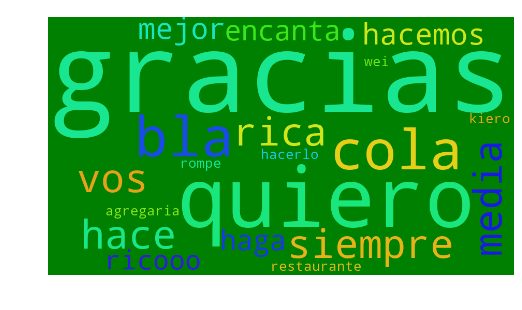

In [132]:
wordcloud1 = WordCloud(width=900,height=500, max_words=20,relative_scaling=1, background_color='green').\
generate(cluster1)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

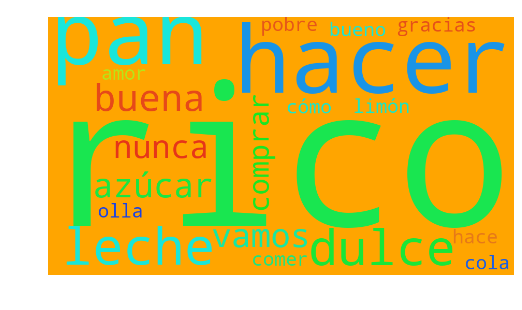

In [134]:
wordcloud2 = WordCloud(width=900,height=500, max_words=20,relative_scaling=1,background_color = 'orange').\
generate(cluster2)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

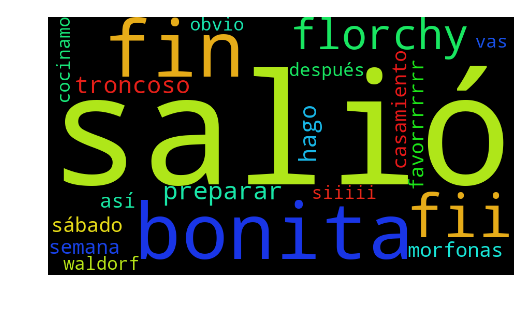

In [135]:
wordcloud3 = WordCloud(width=900,height=500, max_words=20,relative_scaling=1).\
generate(cluster3)
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.show()